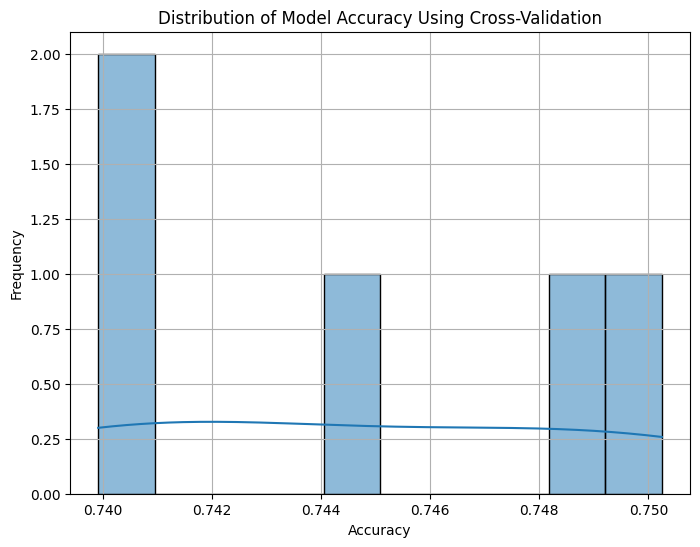

Iteration 1: Accuracy = 0.75
Iteration 2: Accuracy = 0.76
Iteration 3: Accuracy = 0.74
Iteration 4: Accuracy = 0.74
Iteration 5: Accuracy = 0.75


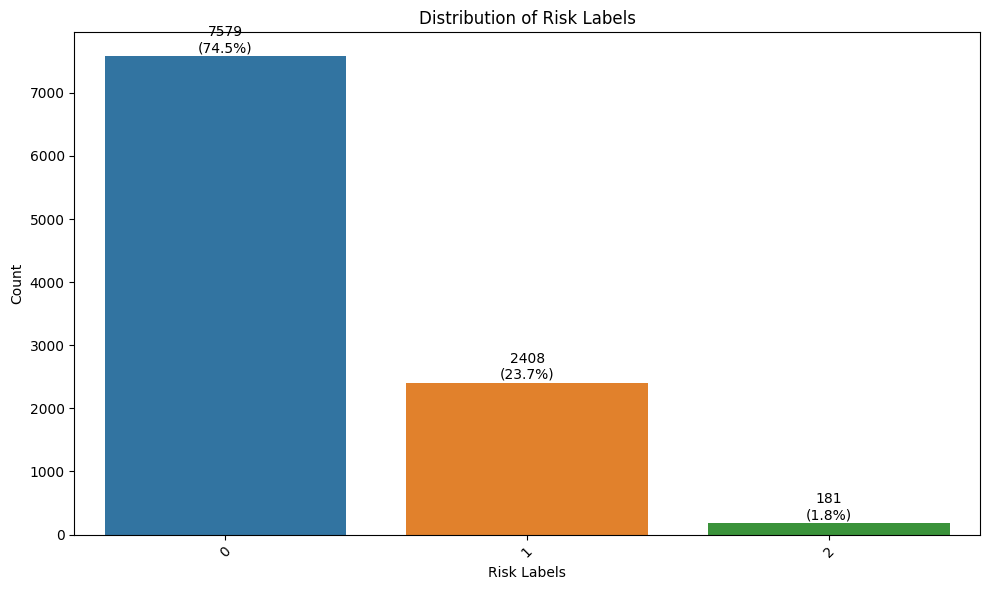

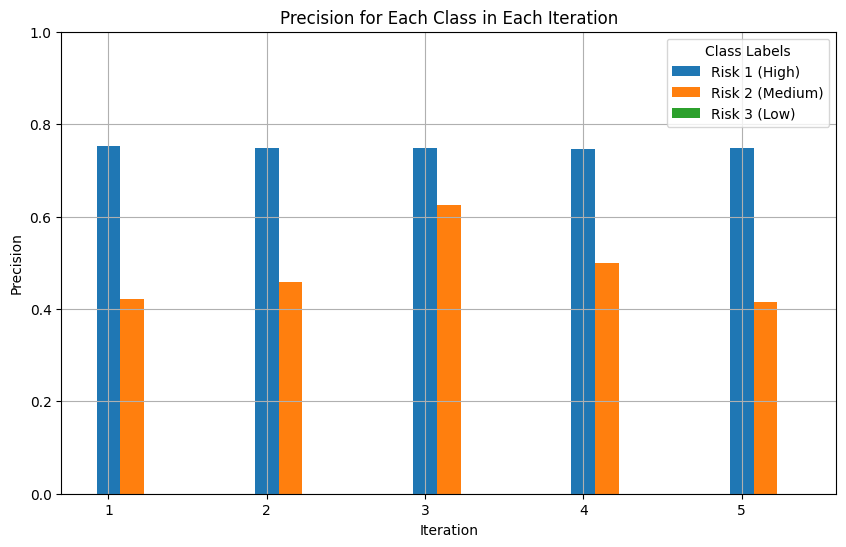

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
db_path = "/content/restaurant.sqlite"
conn = sqlite3.connect(db_path)
query = "SELECT * FROM restaurants"
df_stocks = pd.read_sql_query(query, conn)
conn.close()

# Convert 'Risk' column to numerical using LabelEncoder
label_encoder = LabelEncoder()
df_stocks["Risk"] = label_encoder.fit_transform(df_stocks["Risk"].fillna("Unknown"))

# Select relevant features for prediction
features = ["Results", "zip"]

# Data preparation function
def prepare_data(df):
    X = df[features]
    y = df["Risk"]

    X_encoded = pd.get_dummies(X, columns=["Results", "zip"], drop_first=True)
    imputer = SimpleImputer(strategy="mean")
    X_encoded_imputed = imputer.fit_transform(X_encoded)
    return X_encoded_imputed, y

# Model evaluation function
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    return scores

# Train and evaluate the model
X, y = prepare_data(df_stocks)
model = RandomForestClassifier(n_estimators=100, random_state=42)
accuracy_scores = evaluate_model(model, X, y)

# Plot the accuracy distribution
plt.figure(figsize=(8, 6))
sns.histplot(accuracy_scores, bins=10, kde=True)
plt.title("Distribution of Model Accuracy Using Cross-Validation")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

accuracy_list = []

for iteration in range(1, 6):  # Run the model 5 times with different data splits
    # Shuffle the data
    df_shuffled = df_stocks.sample(frac=1, random_state=np.random.randint(1, 100))

    X = df_shuffled[features]
    y = df_shuffled["Risk"]

    X_encoded = pd.get_dummies(X, columns=["Results", "zip"], drop_first=True)
    imputer = SimpleImputer(strategy="mean")
    X_encoded_imputed = imputer.fit_transform(X_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded_imputed, y, test_size=0.2, random_state=np.random.randint(1, 100))

    model = RandomForestClassifier(n_estimators=100, random_state=np.random.randint(1, 100))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy for the current iteration
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to a list
    accuracy_list.append(accuracy)

    # Print accuracy for the current iteration
    print(f"Iteration {iteration}: Accuracy = {accuracy:.2f}")


# Count the occurrences of each risk label
risk_label_counts = df_stocks["Risk"].value_counts()

# Calculate percentages
total_samples = len(df_stocks)
risk_label_percentages = (risk_label_counts / total_samples) * 100

# Plot the distribution of risk labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=risk_label_counts.index, y=risk_label_counts.values)
plt.title("Distribution of Risk Labels")
plt.xlabel("Risk Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Annotate with counts and percentages
for i, count in enumerate(risk_label_counts):
    ax.text(i, count + 10, f"{count}\n({risk_label_percentages[i]:.1f}%)", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

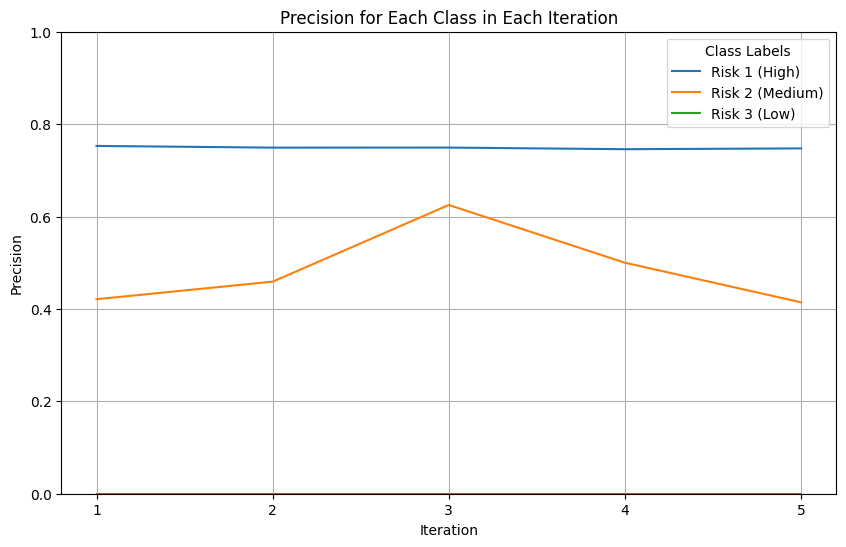

In [21]:
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(label_encoder.classes_):
    precision_values = [report[class_label]["precision"] for report in class_reports]
    plt.plot(np.arange(1, 6), precision_values, label=class_label)

plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.title('Precision for Each Class in Each Iteration')
plt.legend(title="Class Labels", loc="upper right")
plt.xticks(np.arange(1, 6))
plt.ylim(0, 1)
plt.grid(True)
plt.show()